<h2 align='center'>ПРИЛОЖЕНИЕ В</h2>

<p style="text-align: center"><b>Построение LSTM модели в PyTorch</b></p>

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [2]:
import yfinance as yf
from datetime import date, timedelta, datetime

In [3]:
end = date.today().strftime('%Y-%m-%d')
start = '1990-01-01'

df = yf.download('AAPL', start=start, end=end)

[*********************100%%**********************]  1 of 1 completed


In [4]:
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1990-01-02,0.314732,0.334821,0.312500,0.332589,0.263078,183198400
1990-01-03,0.339286,0.339286,0.334821,0.334821,0.264843,207995200
1990-01-04,0.341518,0.345982,0.332589,0.335938,0.265727,221513600
1990-01-05,0.337054,0.341518,0.330357,0.337054,0.266610,123312000
1990-01-08,0.334821,0.339286,0.330357,0.339286,0.268375,101572800
...,...,...,...,...,...,...
2024-04-29,173.369995,176.029999,173.100006,173.500000,173.500000,68169400
2024-04-30,173.330002,174.990005,170.000000,170.330002,170.330002,65934800
2024-05-01,169.580002,172.710007,169.110001,169.300003,169.300003,50383100


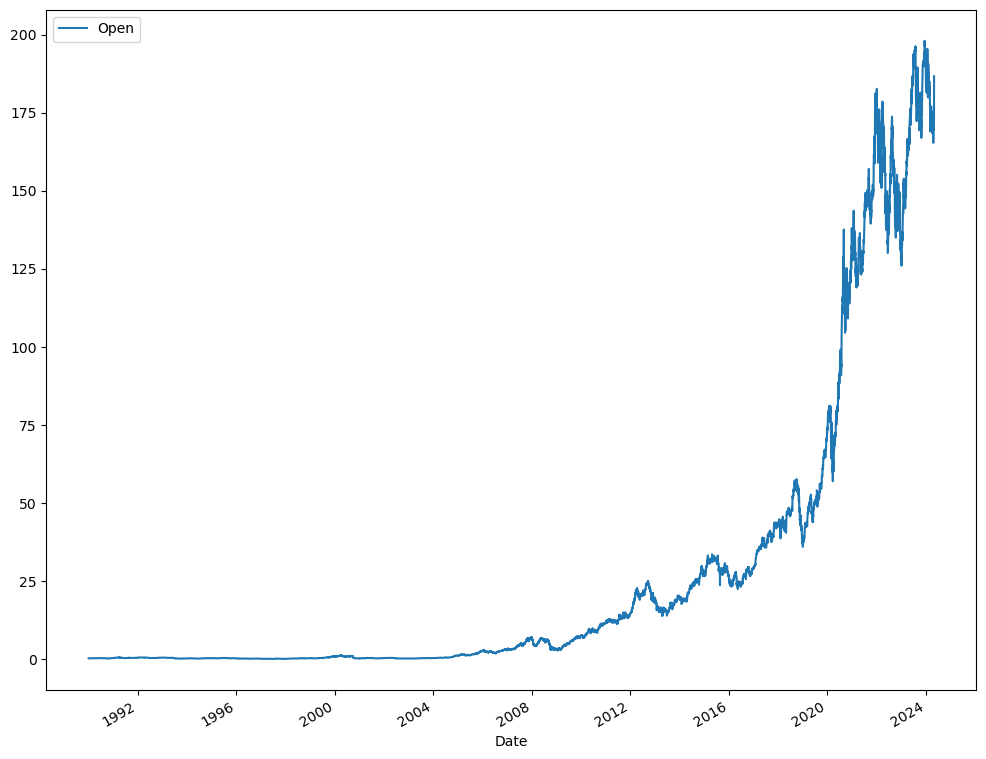

In [5]:
df.iloc[:,:1].plot(figsize=(12, 10));

In [6]:
training_data_len = math.ceil(len(df) * .8)
training_data_len
 
train_data = df[:training_data_len].iloc[:,:1]
test_data = df[training_data_len:].iloc[:,:1]
print(train_data.shape, test_data.shape)

(6921, 1) (1730, 1)


In [7]:
dataset_train = train_data.Open.values
dataset_train = np.reshape(dataset_train, (-1,1))

dataset_train.shape

(6921, 1)

In [8]:
dataset_test = test_data.Open.values
dataset_test = np.reshape(dataset_test, (-1,1))

dataset_test.shape

(1730, 1)

In [9]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))

scaled_train = scaler.fit_transform(dataset_train)
scaled_test = scaler.fit_transform(dataset_test)

In [10]:
sequence_length = 50
X_train, y_train = [], []
for i in range(len(scaled_train) - sequence_length):
    X_train.append(scaled_train[i:i+sequence_length])
    y_train.append(scaled_train[i+1:i+sequence_length+1])
X_train, y_train = np.array(X_train), np.array(y_train)
 
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_train.shape,y_train.shape

(torch.Size([6871, 50, 1]), torch.Size([6871, 50, 1]))

In [11]:
sequence_length = 30
X_test, y_test = [], []
for i in range(len(scaled_test) - sequence_length):
    X_test.append(scaled_test[i:i+sequence_length])
    y_test.append(scaled_test[i+1:i+sequence_length+1])
X_test, y_test = np.array(X_test), np.array(y_test)
 
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)
X_test.shape, y_test.shape

(torch.Size([1700, 30, 1]), torch.Size([1700, 30, 1]))

In [12]:
class LSTMModel(nn.Module):

    def __init__(self, input_size, hidden_size, num_layers): 
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, 1)
 
    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.linear(out)
        return out

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [14]:
input_size = 1
num_layers = 2
hidden_size = 64
output_size = 1
 
model = LSTMModel(input_size, hidden_size, num_layers).to(device)
 
loss_fn = torch.nn.MSELoss(reduction='mean')
 
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
print(model)

LSTMModel(
  (lstm): LSTM(1, 64, num_layers=2, batch_first=True)
  (linear): Linear(in_features=64, out_features=1, bias=True)
)


In [15]:
batch_size = 16

train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
 
test_dataset = torch.utils.data.TensorDataset(X_test, y_test)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [16]:
num_epochs = 10
train_hist = []
test_hist = []

for epoch in range(num_epochs):
    total_loss = 0.0
 
    model.train()
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        predictions = model(batch_X)
        loss = loss_fn(predictions, batch_y)
 
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
 
        total_loss += loss.item()
 
    average_loss = total_loss / len(train_loader)
    train_hist.append(average_loss)

    model.eval()
    with torch.no_grad():
        total_test_loss = 0.0
 
        for batch_X_test, batch_y_test in test_loader:
            batch_X_test, batch_y_test = batch_X_test.to(device), batch_y_test.to(device)
            predictions_test = model(batch_X_test)
            test_loss = loss_fn(predictions_test, batch_y_test)
 
            total_test_loss += test_loss.item()
 
        average_test_loss = total_test_loss / len(test_loader)
        test_hist.append(average_test_loss)
    
    print(f'Epoch [{epoch+1}/{num_epochs}] - Training Loss: {average_loss:.4f}, Test Loss: {average_test_loss:.4f}')

Epoch [1/10] - Training Loss: 0.0051, Test Loss: 0.0041
Epoch [2/10] - Training Loss: 0.0003, Test Loss: 0.0003
Epoch [3/10] - Training Loss: 0.0000, Test Loss: 0.0002
Epoch [4/10] - Training Loss: 0.0000, Test Loss: 0.0002
Epoch [5/10] - Training Loss: 0.0000, Test Loss: 0.0002
Epoch [6/10] - Training Loss: 0.0000, Test Loss: 0.0002
Epoch [7/10] - Training Loss: 0.0000, Test Loss: 0.0002
Epoch [8/10] - Training Loss: 0.0000, Test Loss: 0.0002
Epoch [9/10] - Training Loss: 0.0000, Test Loss: 0.0002
Epoch [10/10] - Training Loss: 0.0000, Test Loss: 0.0002


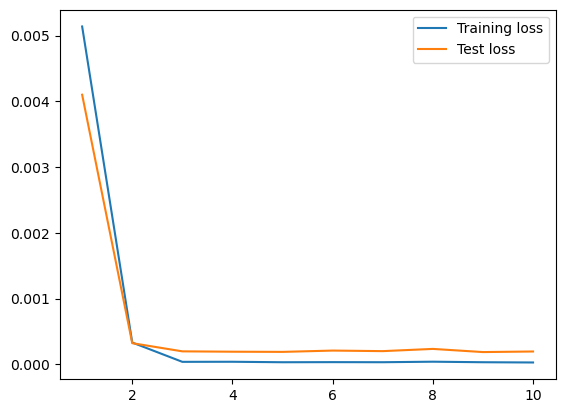

In [17]:
plt.plot(np.linspace(1, num_epochs, num_epochs), train_hist, scalex=True, label='Training loss')
plt.plot(np.linspace(1, num_epochs, num_epochs), test_hist, label='Test loss')
plt.legend()
plt.show();

In [18]:
num_forecast_steps = 30
sequence_to_plot = X_test.squeeze().cpu().numpy()

historical_data = sequence_to_plot[-1]
historical_data.shape

(30,)

In [19]:
forecasted_values = []

with torch.no_grad():
    for _ in range(num_forecast_steps*2):
        historical_data_tensor = torch.as_tensor(historical_data).view(1, -1, 1).float().to(device)
        predicted_value = model(historical_data_tensor).cpu().numpy()[0, 0]
        
        forecasted_values.append(predicted_value[0])
        
        historical_data = np.roll(historical_data, shift=-1)
        historical_data[-1] = predicted_value
        
last_date = test_data.index[-1]
future_dates = pd.date_range(start=last_date+pd.DateOffset(1), periods=30)

combined_index = test_data.index.append(future_dates)

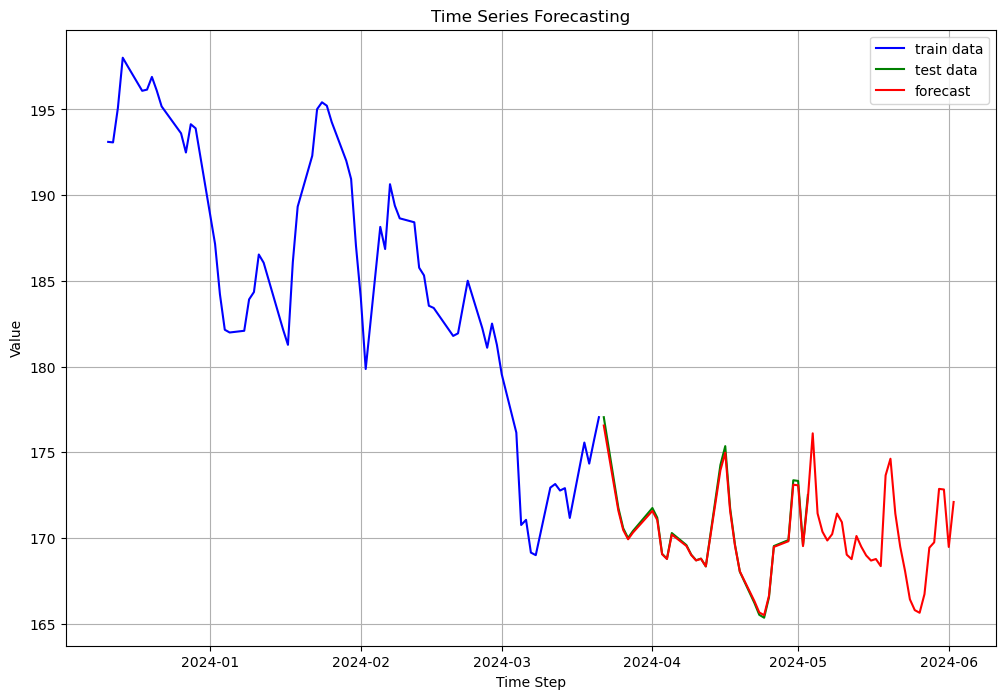

In [20]:
plt.figure(figsize=(12, 8))

plt.plot(test_data.index[-100:-30], test_data.Open[-100:-30], label='train data', color='b')

original_cases = scaler.inverse_transform(np.expand_dims(sequence_to_plot[-1], axis=0)).flatten()
plt.plot(test_data.index[-30:], original_cases, label='test data', color='green')

forecasted_cases = scaler.inverse_transform(np.expand_dims(forecasted_values, axis=0)).flatten()
plt.plot(combined_index[-60:], forecasted_cases, label='forecast', color='red')

plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.title('Time Series Forecasting')
plt.grid(True)
plt.show();

In [21]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

forecasted_cases_30 = forecasted_cases[:30]

# Mean Absolute Percentage Error (MAPE)
def calculate_mape(actual, forecast):
    return np.mean(np.abs((actual - forecast) / actual)) * 100

# Mean Absolute Scaled Error (MASE)
def calculate_mase(actual, forecast, naive_forecast):
    return mean_absolute_error(actual, forecast) / mean_absolute_error(actual, naive_forecast)

# Symmetric Mean Absolute Percentage Error (SMAPE)
def calculate_smape(actual, forecast):
    return 100 * np.mean(2 * np.abs(forecast - actual) / (np.abs(actual) + np.abs(forecast)))

# Рассчитываем прогноз наивной модели (например, просто предыдущее значение)
naive_forecast = np.roll(original_cases, shift=1)

# Рассчитываем все метрики
mae = mean_absolute_error(original_cases, forecasted_cases_30)
mse = mean_squared_error(original_cases, forecasted_cases_30)
rmse = np.sqrt(mse)
mape = calculate_mape(original_cases, forecasted_cases_30)
mase = calculate_mase(original_cases, forecasted_cases_30, naive_forecast)
smape = calculate_smape(original_cases, forecasted_cases_30)
r_squared = r2_score(original_cases, forecasted_cases_30)

print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Percentage Error (MAPE):", mape)
print("Mean Absolute Scaled Error (MASE):", mase)
print("Symmetric Mean Absolute Percentage Error (SMAPE):", smape)
print("R-squared (Coefficient of Determination):", r_squared)

Mean Absolute Error (MAE): 0.1262975
Mean Squared Error (MSE): 0.029045323
Root Mean Squared Error (RMSE): 0.17042689
Mean Absolute Percentage Error (MAPE): 0.07341813761740923
Mean Absolute Scaled Error (MASE): 0.07325837
Symmetric Mean Absolute Percentage Error (SMAPE): 0.07345869089476764
R-squared (Coefficient of Determination): 0.9959853833728924


In [22]:
print("Средняя абсолютная ошибка (MAE):", mae)
print("Среднеквадратичная ошибка (MSE):", mse)
print("Корень из среднеквадратичной ошибки (RMSE):", rmse)
print("Средняя абсолютная ошибка в процентах (MAPE):", mape)
print("Средняя абсолютная масштабированная ошибка (MASE):", mase)
print("Cимметричная средняя абсолютная процентная ошибка (SMAPE):", smape)
print("Коэффициент детерминации (R^2):", r_squared)

Средняя абсолютная ошибка (MAE): 0.1262975
Среднеквадратичная ошибка (MSE): 0.029045323
Корень из среднеквадратичной ошибки (RMSE): 0.17042689
Средняя абсолютная ошибка в процентах (MAPE): 0.07341813761740923
Средняя абсолютная масштабированная ошибка (MASE): 0.07325837
Cимметричная средняя абсолютная процентная ошибка (SMAPE): 0.07345869089476764
Коэффициент детерминации (R^2): 0.9959853833728924
